# Underlying distributions of all the features in the dataset

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from transformers import BertTokenizer
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import re

In [2]:
import numpy as np
import seaborn as sns
import matplotlib
import scipy
print(f"NumPy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

NumPy version: 2.0.2
Seaborn version: 0.13.2
SciPy version: 1.13.1
matplotlib version: 3.9.4


In [3]:
import nltk

nltk.download("wordnet")
nltk.download("punkt")
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\agupt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Load Data
train = pd.read_csv('../public_data/train/track_a/eng.csv')
val = pd.read_csv('../public_data/dev/track_a/eng_a.csv')
emotions = ['Joy', 'Sadness', 'Surprise', 'Fear', 'Anger']

# Optimal Preprocessing Config
config = {'sep_pn': True, 'rm_pn': False, 'apply_lemmatization': True, 'apply_stemming': True, 'add_bigrams': True, 'rm_sw': False}

# Preprocessing Functions
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load("en_core_web_sm")

def pre_process(text, config):
    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    return " ".join(tokens)

# Preprocess and Extract Features
vectorizer = CountVectorizer()

train_text = [pre_process(text, config) for text in train["text"]]
val_text = [pre_process(text, config) for text in val["text"]]

X_train = vectorizer.fit_transform(train_text).toarray()
X_val = vectorizer.transform(val_text).toarray()

# POS Tagging
def extract_pos_tags(texts):
    return [[token.pos_ for token in nlp(text)] for text in texts]

train_pos_tags = extract_pos_tags(train["text"])
val_pos_tags = extract_pos_tags(val["text"])

# POS Encoding
max_length = max(max(len(tags) for tags in train_pos_tags), max(len(tags) for tags in val_pos_tags))
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)

# Combine Features
combined_features = np.concatenate((X_train, train_pos_encoded), axis=1)
validation_combined_features = np.concatenate((X_val, val_pos_encoded), axis=1)

# Logistic Regression for Enhanced Features
y_train = train[emotions].values
lr = LogisticRegression(max_iter=1000)
lr.fit(combined_features, np.argmax(y_train, axis=1))

lr_features = lr.predict_proba(combined_features)
val_lr_features = lr.predict_proba(validation_combined_features)

final_train_features = np.concatenate((combined_features, lr_features), axis=1)
final_val_features = np.concatenate((validation_combined_features, val_lr_features), axis=1)

In [5]:
# 2. Plot underlying distribution of the features

print(final_train_features)


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.20506391e-02
  2.01655049e-02 1.49306960e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.49346522e-09
  8.24324511e-08 5.98760918e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.23140252e-04
  9.97181024e-03 2.54089790e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.56968060e-02
  8.34986121e-03 1.26594647e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.38835343e-01
  3.18270486e-03 1.67673294e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.36919321e-02
  2.89557066e-02 3.27476383e-04]]


C:\Users\agupt\AppData\Local\Temp\ipykernel_34984\3133889194.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


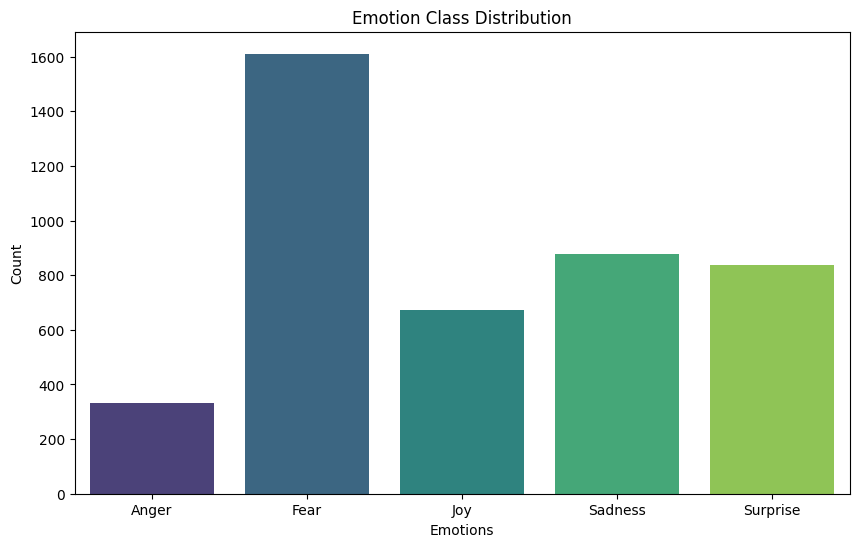

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class Distribution
emotions = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
class_counts = train[emotions].sum()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Emotion Class Distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()


In [7]:
pd.DataFrame(class_counts)

0
Anger      333
Fear      1611
Joy        674
Sadness    878
Surprise   839

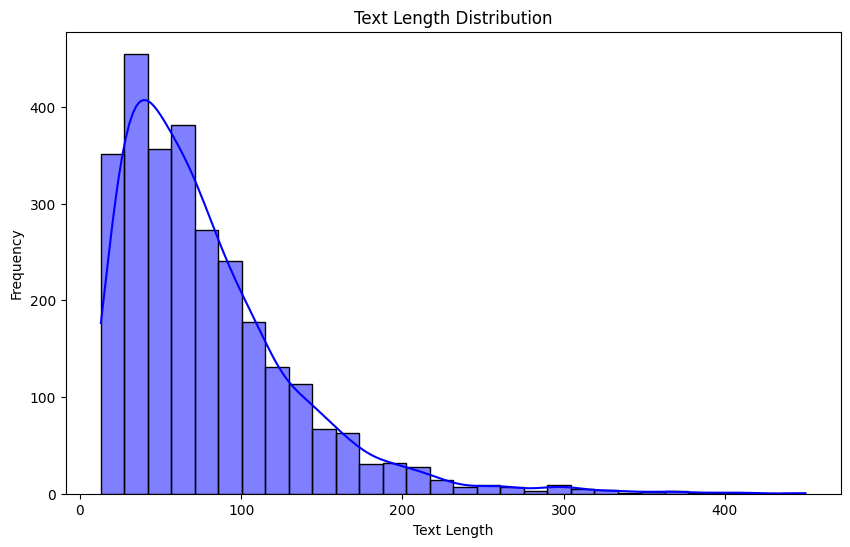

In [8]:
# Add a new column for text lengths
train['text_length'] = train['text'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(train['text_length'], bins=30, kde=True, color='blue')
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

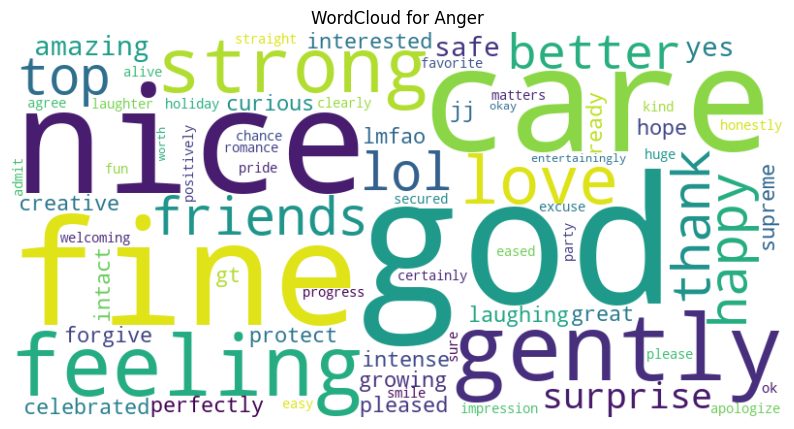

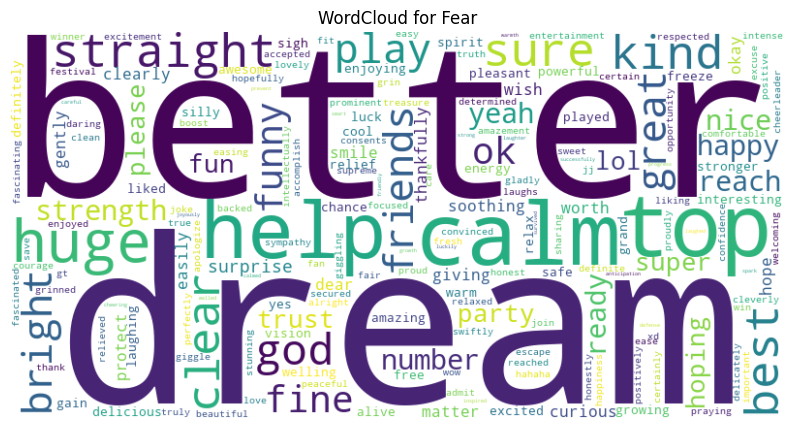

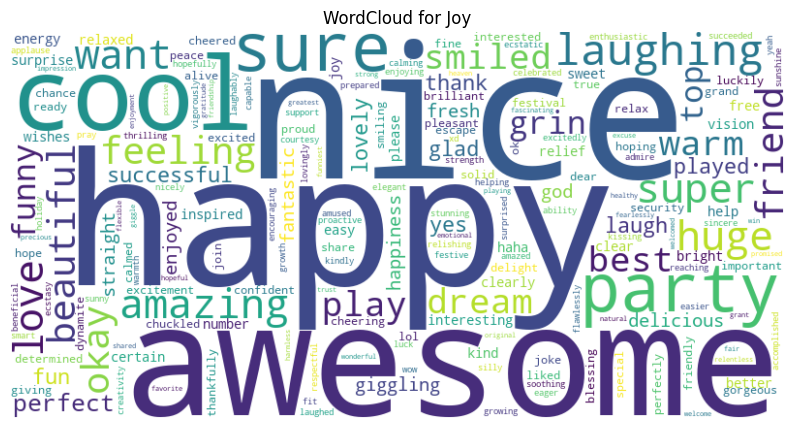

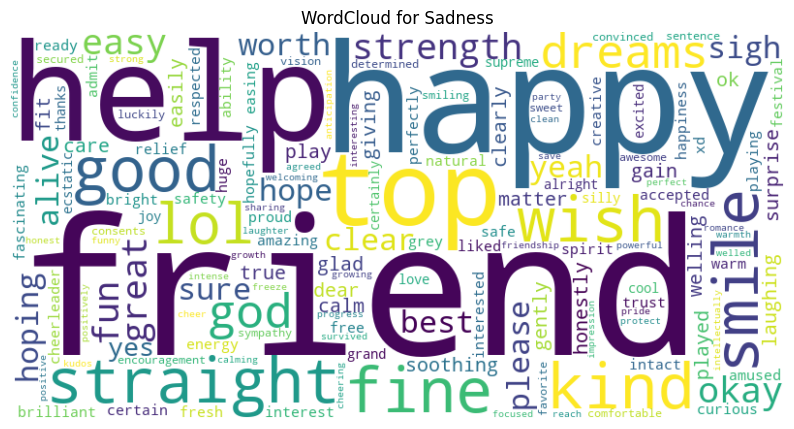

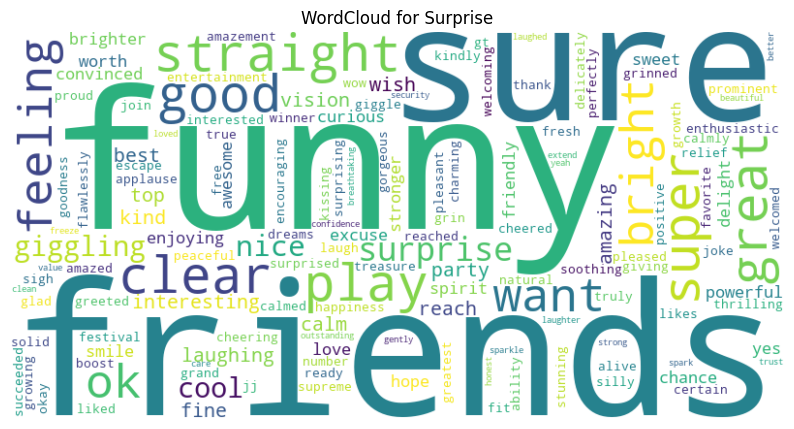

In [9]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Get English stopwords
stopwords = set(stopwords.words('english'))

def filter_text_dynamic(text):
    # Lowercase and remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    
    # Score words based on sentiment
    words = text.split()
    relevant_words = [
        word for word in words 
        if word not in stopwords and sia.polarity_scores(word)['pos'] > 0.5  # Adjust threshold as needed
    ]
    
    return " ".join(relevant_words)

def remove_top_words(text, top_n=10):
    # Count word frequencies
    word_counts = Counter(text.split())
    
    # Identify the top N words
    top_words = [word for word, _ in word_counts.most_common(top_n)]
    
    # Filter out top words from text
    filtered_text = " ".join(word for word in text.split() if word not in top_words)
    
    return filtered_text

def plot_word_cloud(emotion):
    # Combine all text where the specific emotion is present
    text_data = " ".join(train[train[emotion] == 1]['text'].values)
    
    # Debug: Check if text_data is empty
    if not text_data:
        print(f"No text found for emotion: {emotion}")
        return
    
    # Filter the text data dynamically
    filtered_text = filter_text_dynamic(text_data)
    
    # Remove top words from the filtered text
    filtered_text = remove_top_words(filtered_text, top_n=8)
    
    # Debug: Check if filtered_text is empty
    if not filtered_text:
        print(f"No relevant words found for emotion: {emotion}")
        return

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(filtered_text)

    # Display the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {emotion}")
    plt.show()

# Generate word clouds for each emotion
for emotion in emotions:
    plot_word_cloud(emotion)

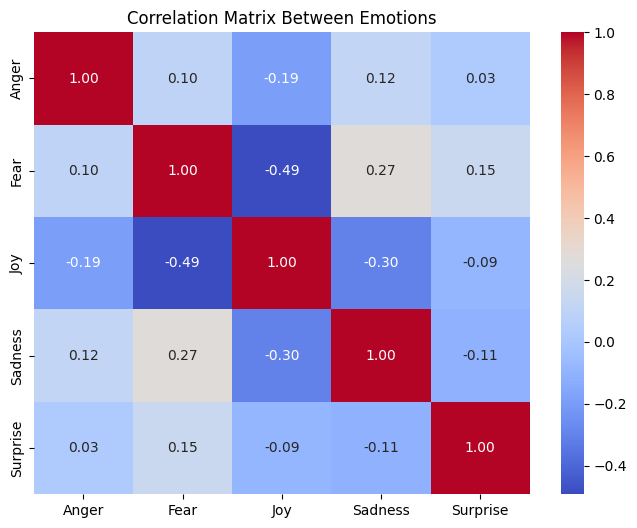

In [8]:
# Compute the correlation matrix
correlation_matrix = train[emotions].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Between Emotions")
plt.show()


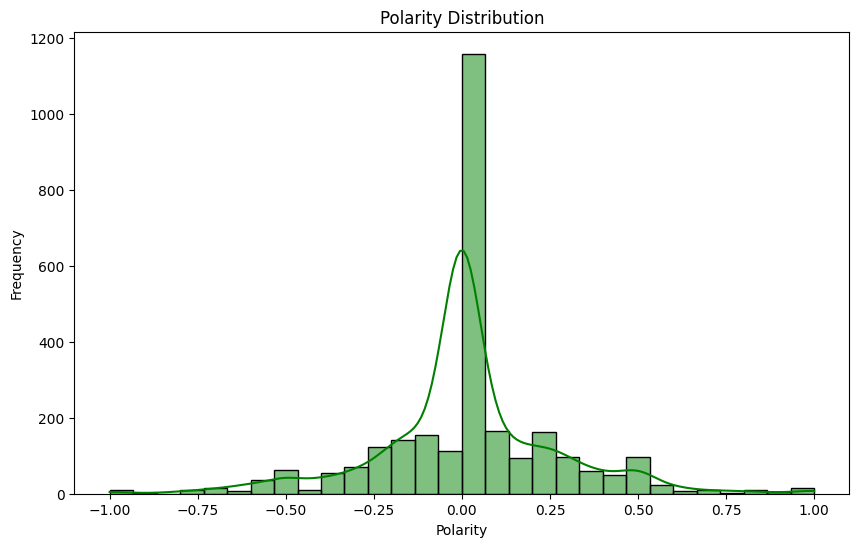

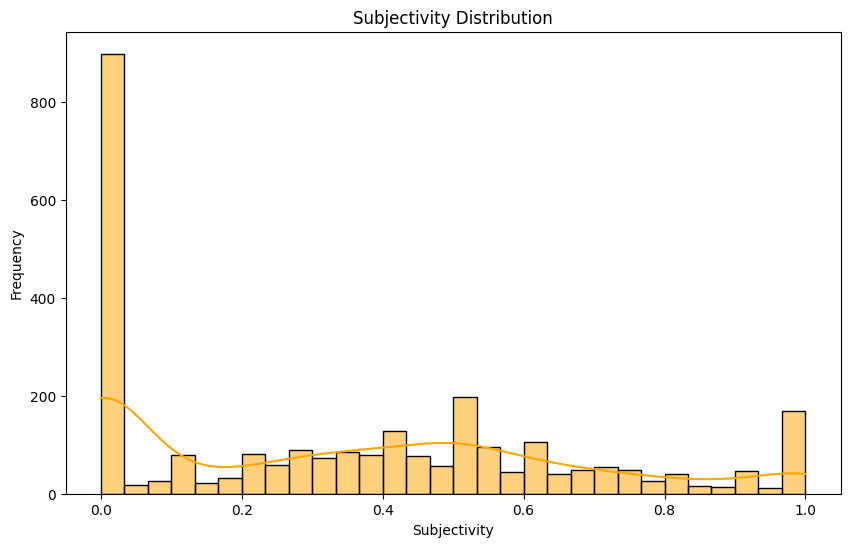

In [9]:
from textblob import TextBlob

# Add sentiment polarity and subjectivity
train['polarity'] = train['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['subjectivity'] = train['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Plot polarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['polarity'], bins=30, kde=True, color='green')
plt.title("Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()

# Plot subjectivity distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['subjectivity'], bins=30, kde=True, color='orange')
plt.title("Subjectivity Distribution")
plt.xlabel("Subjectivity")
plt.ylabel("Frequency")
plt.show()


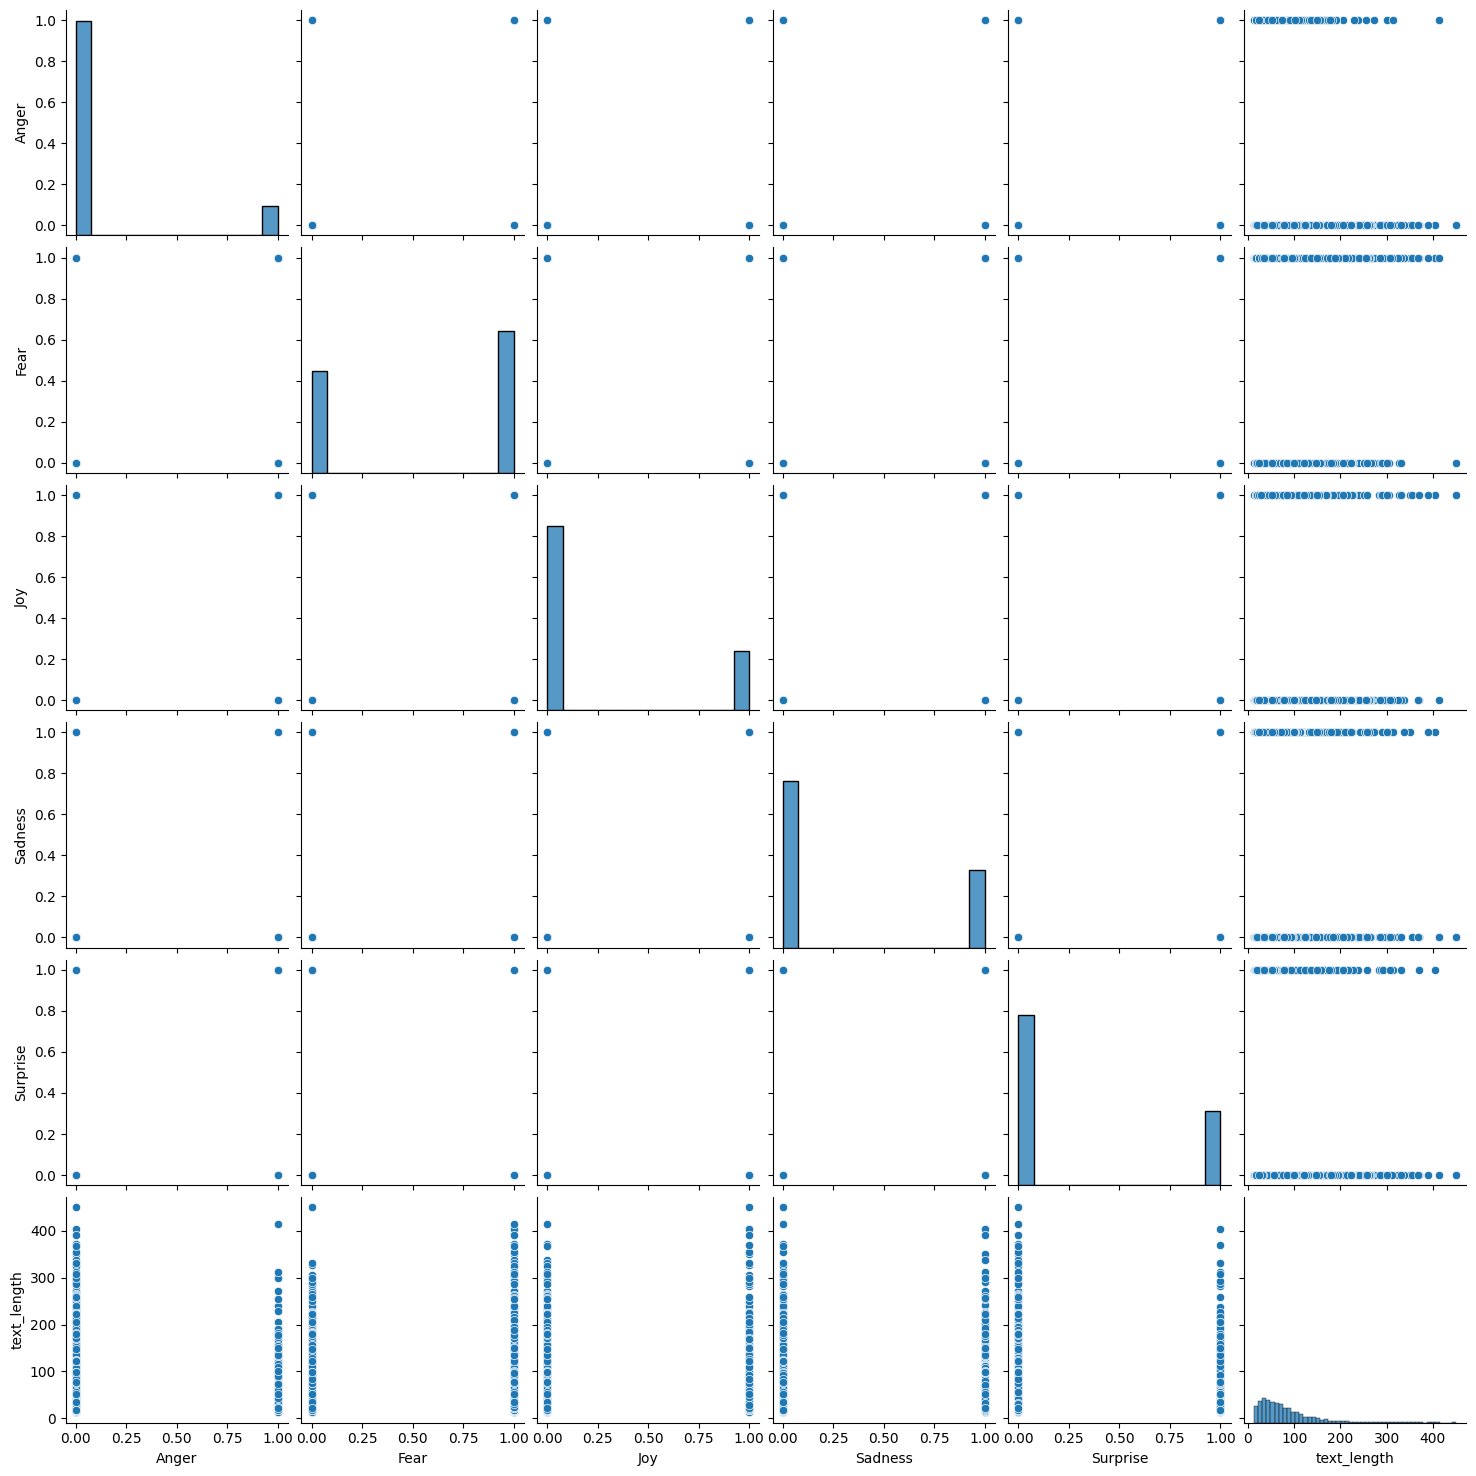

In [28]:
sns.pairplot(train[emotions + ['text_length']])
plt.show()

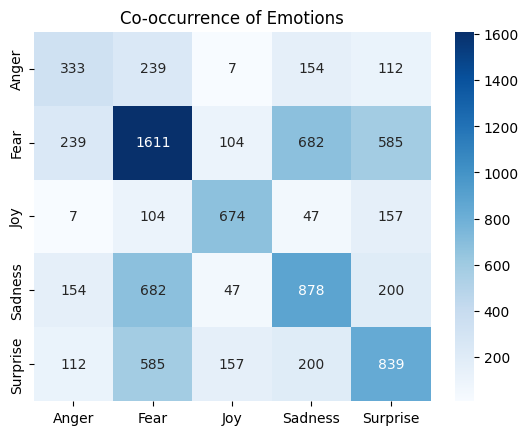

In [16]:
co_occurrence = train[emotions].T.dot(train[emotions])
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='Blues')
plt.title('Co-occurrence of Emotions')
plt.show()

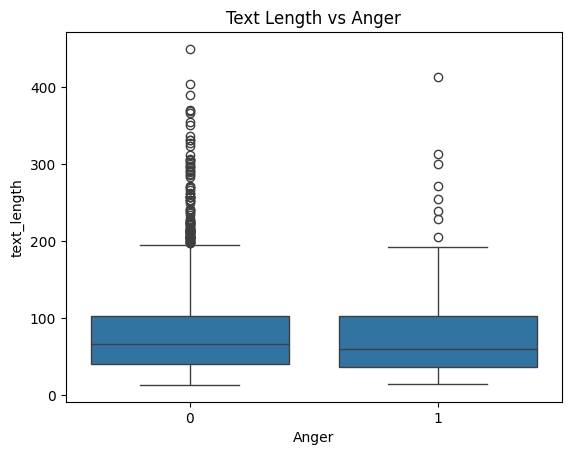

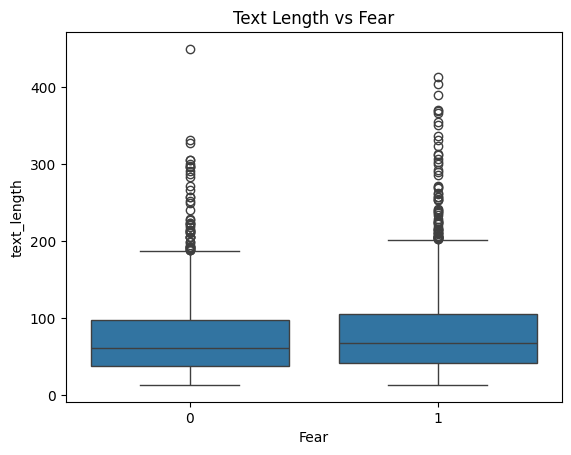

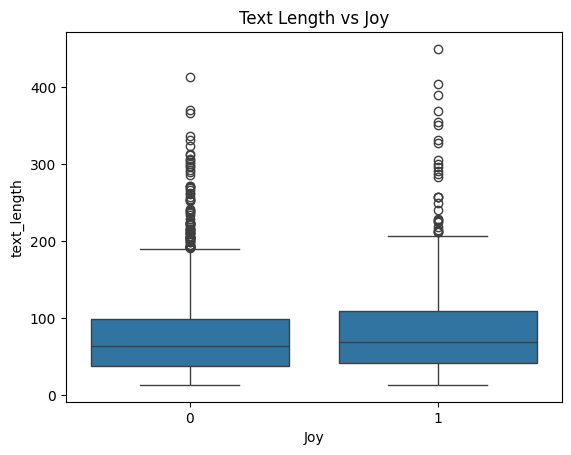

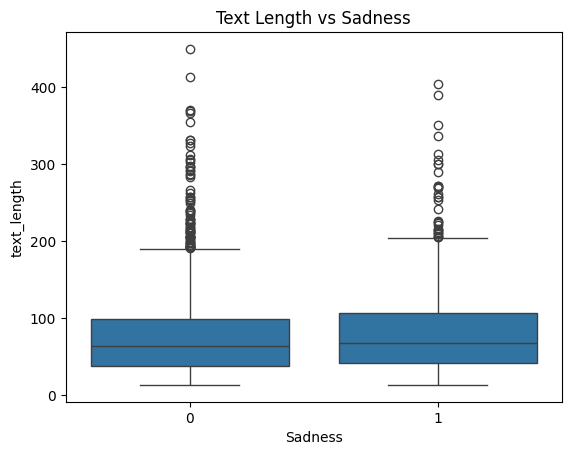

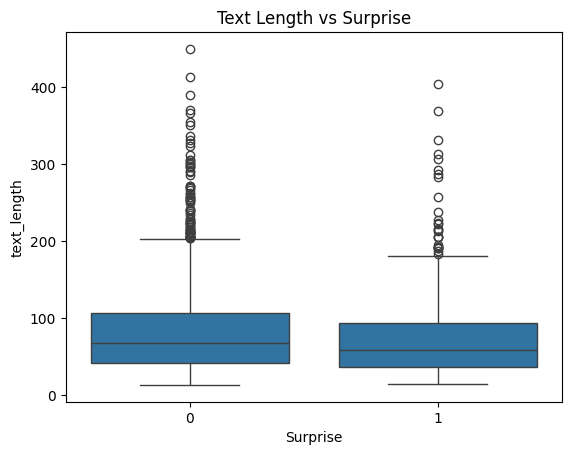

In [31]:
emotions = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
for i in emotions:
    train['text_length'] = train['text'].apply(len)
    sns.boxplot(data=train, x=i, y='text_length')  
    plt.title(f'Text Length vs {i}')
    plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

for emotion in emotions:
    subset = train[train[emotion] == 1]
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(subset['text'])
    words = vectorizer.get_feature_names_out()
    frequencies = word_counts.sum(axis=0).A1
    word_freq = pd.DataFrame({'word': words, 'count': frequencies}).sort_values(by='count', ascending=False)
    print(f"Top words for {emotion}:\n", word_freq.head())

word  count
1098     just     41
1174     like     37
710      eyes     35
954      head     33
711      face     28
...       ...    ...
2309  working      1
2308   worker      1
621   drowned      1
620     drove      1
16        2am      1

[2338 rows x 2 columns]

In [32]:
train.head()

id                                               text  \
0  eng_train_track_a_00001                                But not very happy.   
1  eng_train_track_a_00002  Well she's not gon na last the whole song like...   
2  eng_train_track_a_00003  She sat at her Papa's recliner sofa only to mo...   
3  eng_train_track_a_00004                    Yes, the Oklahoma city bombing.   
4  eng_train_track_a_00005                       They were dancing to Bolero.   

   Anger  Fear  Joy  Sadness  Surprise  polarity  subjectivity  text_length  
0      0     0    1        1         0 -0.307692      0.769231           19  
1      0     0    1        0         0  0.015741      0.442593          193  
2      0     0    0        0         0  0.000000      0.500000           90  
3      1     1    0        1         1  0.000000      0.000000           31  
4      0     0    1        0         0  0.000000      0.000000           28

## Feature Analysis

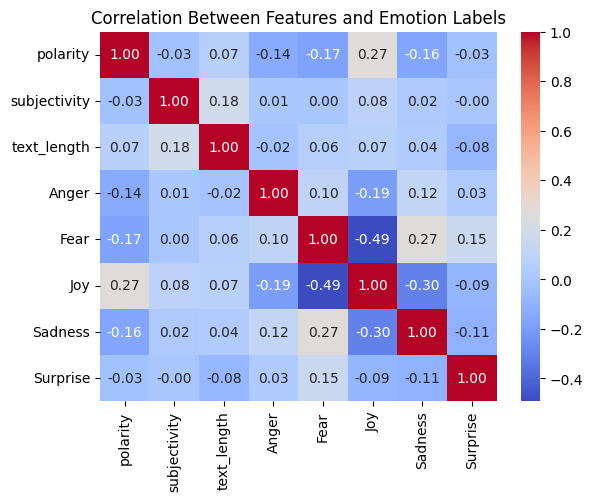

In [34]:
# Correlation Heatmap
correlation = train[['polarity', 'subjectivity', 'text_length', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Features and Emotion Labels')
plt.show()

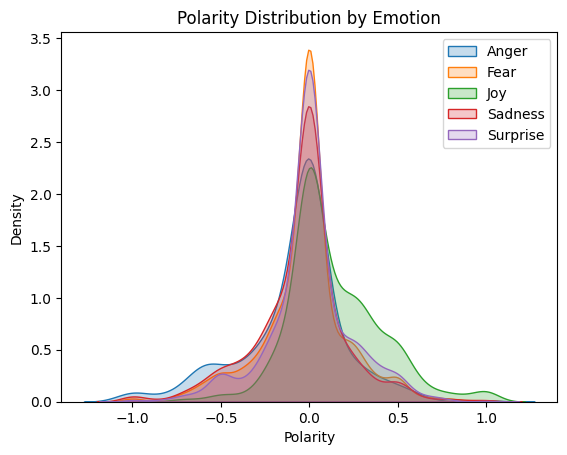

In [37]:
# Example: Polarity Distribution by Emotion
for emotion in ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']:
    sns.kdeplot(train.loc[train[emotion] == 1, 'polarity'], label=emotion, fill=True)
plt.title('Polarity Distribution by Emotion')
plt.xlabel('Polarity')
plt.legend()
plt.show()

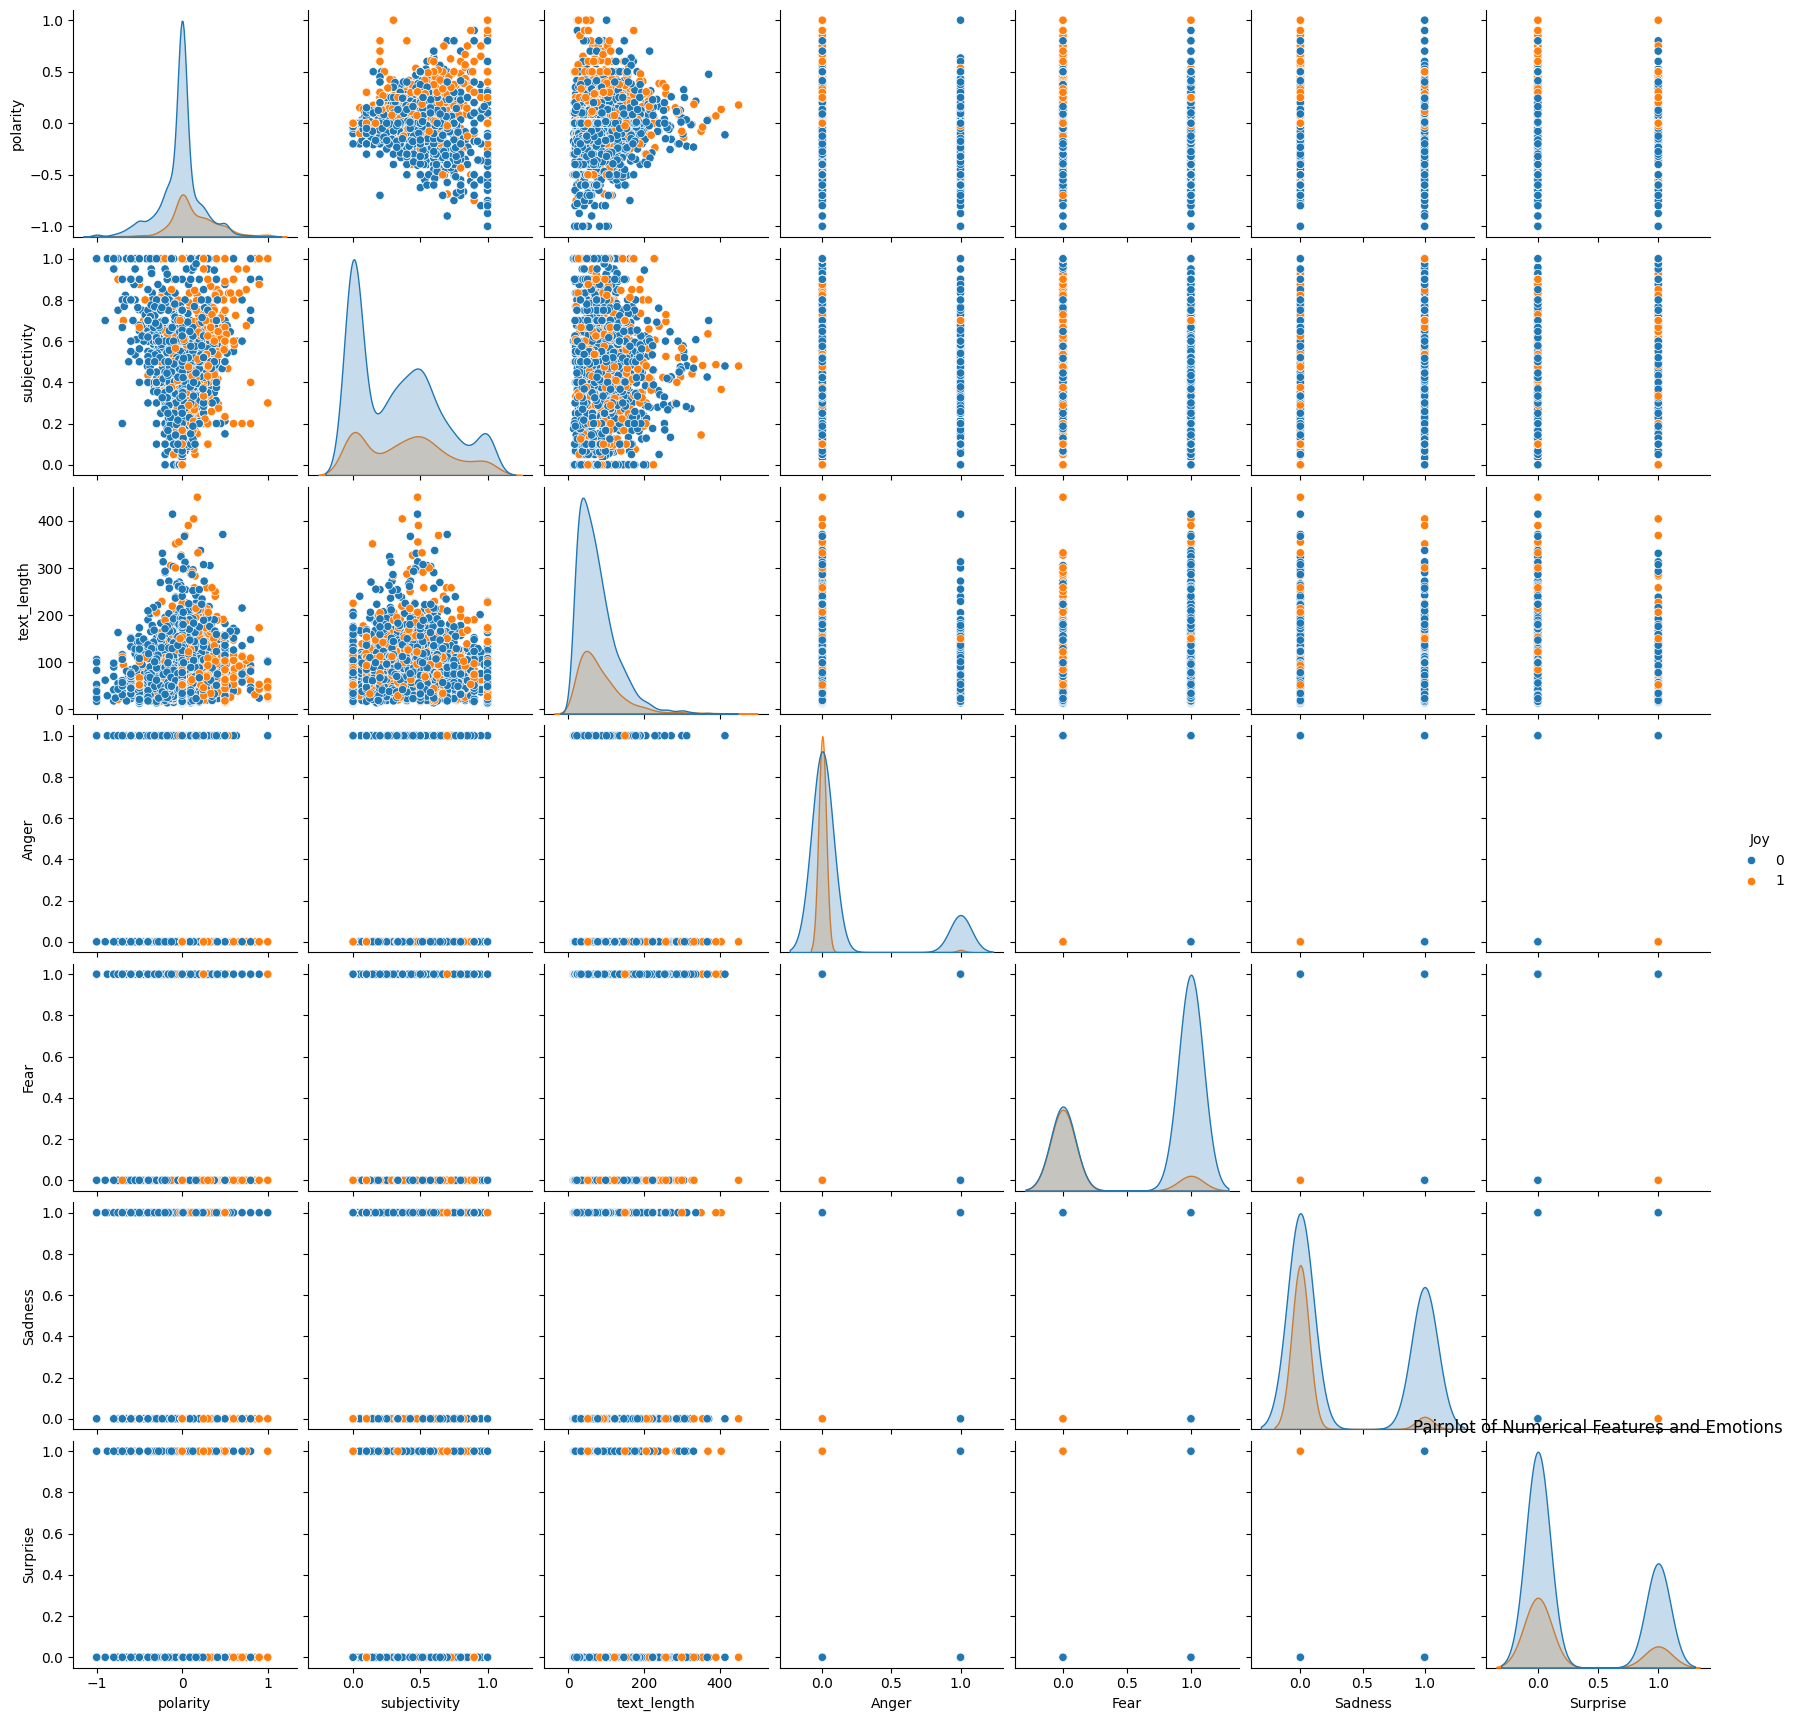

In [41]:
sns.pairplot(train[['polarity', 'subjectivity', 'text_length'] + ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']], hue='Joy')
plt.title('Pairplot of Numerical Features and Emotions')
plt.show()

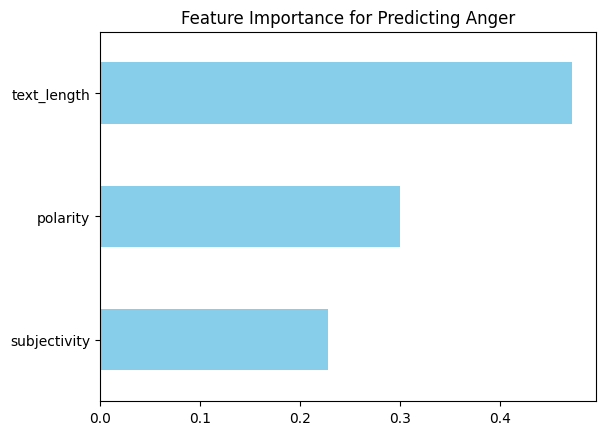

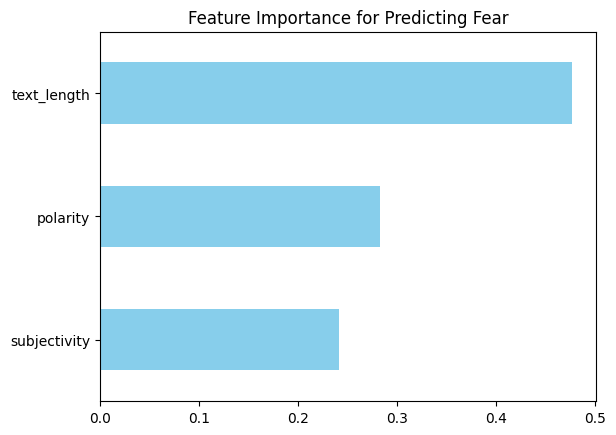

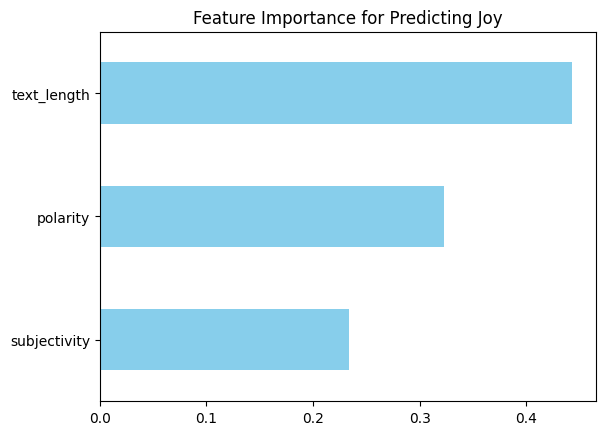

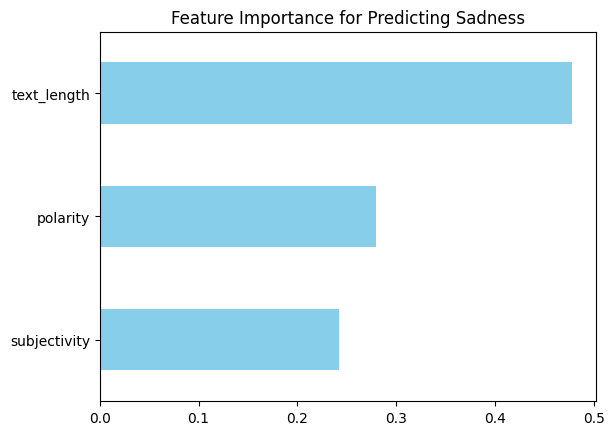

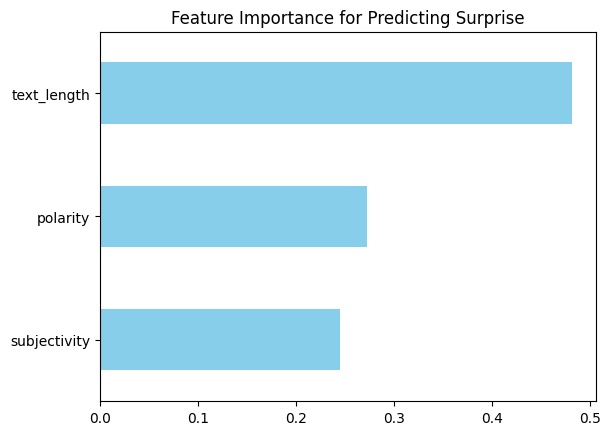

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Preparing the data
X = train[['polarity', 'subjectivity', 'text_length']]
for i in emotions:
    y = train[i] 
    # Train a Random Forest
    rf = RandomForestClassifier()
    rf.fit(X, y)

    # Plot feature importances
    importance = pd.Series(rf.feature_importances_, index=X.columns)
    importance.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'Feature Importance for Predicting {i}')
    plt.show()

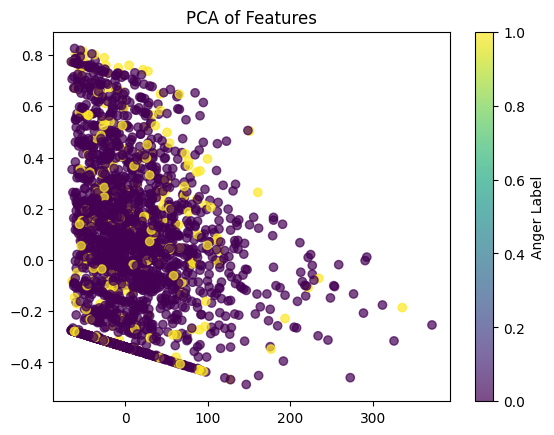

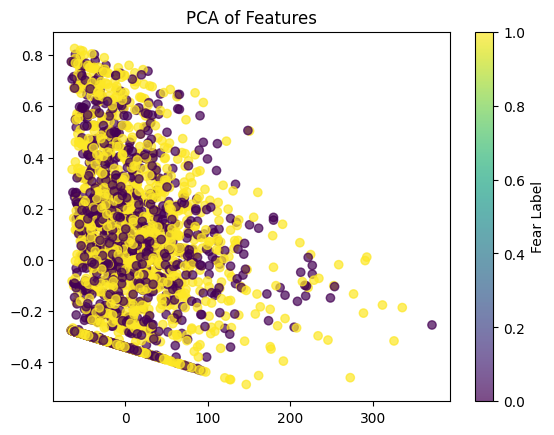

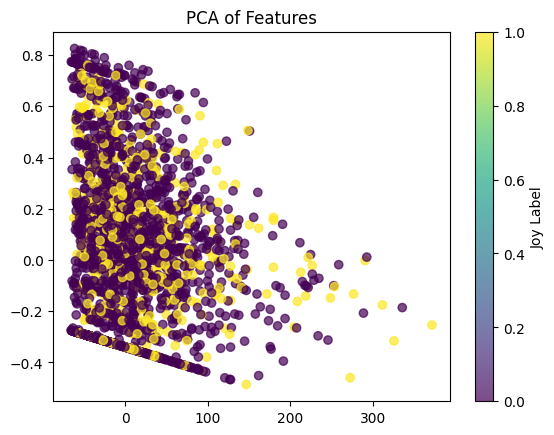

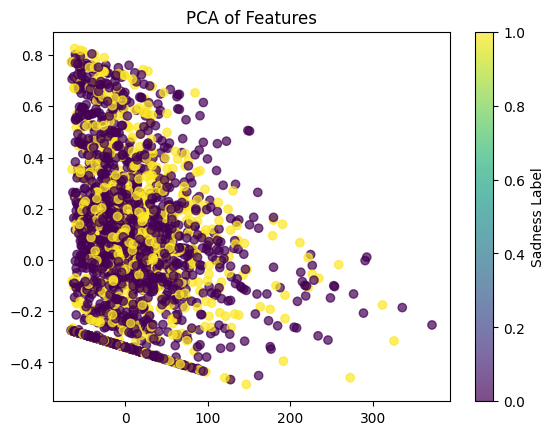

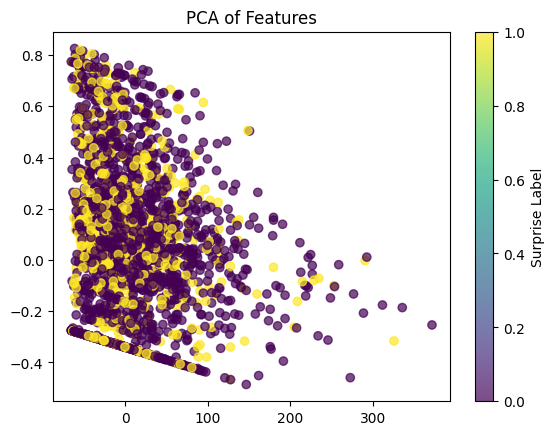

In [49]:
from sklearn.decomposition import PCA

# PCA for 2D Visualization
X = train[['polarity', 'subjectivity', 'text_length']]
pca = PCA(n_components=2)
reduced = pca.fit_transform(X)

for i in emotions:
    # Plot the PCA results
    plt.scatter(reduced[:, 0], reduced[:, 1], c=train[i], cmap='viridis', alpha=0.7)
    plt.colorbar(label=f'{i} Label')
    plt.title('PCA of Features')
    plt.show()